# Isala Sex Prediction

In [1]:
import sys
sys.path.append('/home/thies/repos/BIU/')
import biu
import numpy as np
import scipy
import pandas as pd
import matplotlib.pylab as plt
plt.rcParams['svg.fonttype'] = 'none'
import seaborn as sns

In [2]:
blue = '#00719A'
pink = '#FCD0BE'

import matplotlib.colors as clr
blue_cmap = clr.LinearSegmentedColormap.from_list('custom blue', ['#FFFFFF',blue], N=256)
pink_cmap = clr.LinearSegmentedColormap.from_list('custom pink', ['#FFFFFF',pink], N=256)
bluepink_cmap  = clr.LinearSegmentedColormap.from_list('custom bluepink', [blue, '#FFFFFF', pink], N=512)


In [3]:
I = biu.db.ISALA2()
R = biu.R()

In [4]:
HQS = I.HQS.reset_index().set_index('participant').join(I.Q[['A.Intercourse']]).reset_index().set_index('sample_id')
HQS = HQS[HQS['A.Intercourse'].isin(['No','Yes'])]
isala_intercourse = HQS[['A.Intercourse']].rename(columns={"A.Intercourse":"intercourse"})

In [5]:
R("""

library(tidyamplicons)
library(tidyverse)
genedoe_rds <- "~/repos/UA_underwear/data/genedoe_taxonomy_fixed_qc_reclassified_premda.rds"
isala_rds <- '/home/thies/repos/UA_isala/data/16S/flow1_merged_with20210908.20220414.rds'
rapekit_rds <- "/home/thies/repos/UA_underwear/data/run_GeneDoe_SAS_vagina.rda"

gd <- readRDS(genedoe_rds)
is <- readRDS(isala_rds)
rk <- load(rapekit_rds)
rk <- run_SAS_DNA_vagina
rk$taxa <- rk$taxa[,c('kingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species', 'taxon', 'taxon_id')]

is

gd$samples$dataset <- rep("genedoe", length(gd$samples$sample_id))
is$samples$dataset <- rep("isala", length(is$samples$sample_id))
rk$samples$dataset <- unlist(lapply(rk$sample$fraction, function(x){paste0(c('rapekit',x),collapse='_')}))

#######################
# Set intercourse label Isala
is$samples <- left_join(is$sample, intercourse, by="sample_id")
is <- is %>% filter_samples(!is.na(is$sample$intercourse))

#######################
# Set intercourse label GeneDoe
gd <- filter_samples(gd, condition == "Vaginal FLOQSwab")
gd$samples$intercourse <- rep(NULL, length(gd$samples$condition))
gd$samples$intercourse[(gd$samples$explanation == 'Day 1')] <- "No"
gd$samples$intercourse[(gd$samples$explanation == 'Day 2')] <- "Yes"

#######################
# Set intercourse label Rapekit
aggregate_samples <- function(ta, by=NULL) {

  by <- if (is.null(by)){colnames(ta$samples)} else {c(by,"sample_id")}

  # sample table with only old and new sample names
  names <- ta$samples %>%
    select(by) %>%
    select(- sample_id) %>%
    distinct() %>%
    mutate(sample_id_new = paste("m", 1:n(), sep = "")) %>%
    right_join(ta$samples) %>%
    select(sample_id, sample_id_new)

  # adapt sample table with new names
  ta$samples <- ta$samples %>%
    left_join(names, by = "sample_id") %>%
    select(c(by,'sample_id_new')) %>%
    select(- sample_id) %>%
    rename(sample_id = sample_id_new) %>%
    distinct()

  # merge samples in abundance table and adapt with new names
  ta$abundances <- ta$abundances %>%
    left_join(names, by = "sample_id") %>%
    select(- sample_id) %>%
    group_by(sample_id_new, taxon_id) %>%
    summarize(abundance = sum(abundance)) %>%
    ungroup() %>%
    rename(sample_id = sample_id_new)

  # return ta object
  ta

}

rk <- rk %>% filter_samples(fraction %in% c("SF","VF"))
rkn <- aggregate_samples(rk, "SAS_number")
rkn$samples$dataset <- rep("rapekit_full", length(rkn$samples$sample_id))

rkm <- merge_tidyamplicons(rk, rkn, "taxon")
rkm$samples$intercourse <- rep("Yes", length(rkm$samples$sample_id))
rkm <- filter_samples(rkm, !duplicated(rkm$samples[ , c("SAS_number","dataset")])) # Remove duplicates

#is$samples <- is$samples[,c("sample_id","dataset","intercourse")]
#gd$samples <- gd$samples[,c("sample_id","dataset","intercourse")]
#rkm$samples <- rkm$samples[,c("sample_id","dataset","intercourse")]

# Merge all
mg <- merge_tidyamplicons(rkm, merge_tidyamplicons(gd, is, taxon_identifier="taxon"), taxon_identifier="taxon")
mg_genus <- aggregate_taxa(mg, "genus")
1
""", push=dict(intercourse=isala_intercourse.reset_index()))

S = R("mg_genus$samples").set_index('sample_id')
S.intercourse = S.intercourse.apply(lambda x: 1 if x == 'Yes' else 0)
T = R("mg_genus$taxa")
A = R("mg_genus$abundance").pivot(index="sample_id", columns="taxon_id", values="abundance").fillna(0)
AR = biu.analysis.microbiome.process.relative(A)

AR_clr =  AR.apply(lambda x: np.log(x) - np.log(scipy.stats.gmean(x[x>min(x)])), axis=1)

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

R[write to console]: ✔ ggplot2 3.4.4     ✔ purrr   1.0.2
✔ tibble  3.2.1     ✔ dplyr   1.1.4
✔ tidyr   1.3.0     ✔ stringr 1.5.1
✔ readr   2.1.5     ✔ forcats 1.0.0

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::everything() masks tidyr::everything(), tidyamplicons::everything()
✖ dplyr::filter()     masks stats::filter()
✖ dplyr::lag()        masks stats::lag()



Joining with `by = join_by(SAS_number)`
`summarise()` has grouped output by 'sample_id_new'. You can override using the
`.groups` argument.


In [6]:
SA_isala = S[S.dataset == 'isala'][['participant','intercourse']].join(AR_clr)
SA_rapekit = S[S.dataset.apply(lambda x: 'rapekit' in x)][['dataset','SAS_number','intercourse']].join(AR_clr)
SA_genedoe = S[S.dataset == 'genedoe'][['explanation','participant','intercourse']].join(AR_clr)

# Stratified XV with elastic net

In [7]:
def stratify(data, ngroups, stratvar=None, categorical=None, balanced=False):

    def balanced_cat_labels(n, ngroups, ntotal):
        npergroup = int(ntotal/ngroups)
        bl = list(range(ngroups)) * npergroup + [ -1 ] * (n - (ngroups*npergroup))
        return np.random.permutation(bl)
    #edef
    
    def unbalanced_cat_labels(n, ngroups):
        l = (list(range(ngroups))*int(1+n/ngroups))[:n]
        return np.random.permutation(l)
    
    def stratify_cat(data, ngroups):
        groups = np.zeros(data.shape)-1
        n = { cat : sum(data == cat) for cat in set(data) }
        minn = min(n.values())
        for cat in set(data):
            labels = balanced_cat_labels(n[cat], ngroups, minn) if balanced else unbalanced_cat_labels(n[cat], ngroups)
            groups[data == cat] = labels
        #efor
        return np.array(groups)
    #edef

    def stratify_num(data, ngroups):
        groups = np.zeros(data.shape)-1
        npergroup = (data.shape[0]/ngroups) + 1 # pseudocount
        group_options = [ k for i in range(int(npergroup)) for k in np.random.permutation(list(range(ngroups))) ]
        srt = sorted(enumerate(data), key=lambda x: x[1])
        group_probs = np.array([ 1/ngroups for i in range(ngroups) ])
        for (value_i,v),g in zip(srt, group_options) :
            groups[value_i] = g
        #efor
        return np.array(groups)
    #edef
    
    if stratvar is not None:
        data = data[stratvar]
    #fi
    
    if categorical or (hasattr(data, "dtype") and  (str(data.dtype) in ['object','category'])):
        data = np.array(data)
        return stratify_cat(data, ngroups)
    else:
        data = np.array(data)
        return stratify_num(data, ngroups)
    #fi
#edef

def xv(data, nfolds, stratvar, yvar, xvars, categorical=True, balanced=True):
    folds = stratify(data, nfolds, stratvar, categorical=categorical, balanced=balanced)

    preds = np.zeros(data.shape[0])-1
    weights = []
    for fold in range(nfolds):
        print("\r%d/%d" % ((fold+1), nfolds), end="")
        train = data[ (folds != fold) & (folds >= 0) ]
        test  = data[ (folds == fold) ]
        res = R("""
            library(glmnet)
            model <- cv.glmnet(as.matrix(trainx), family='binomial', trainy, alpha=0.5)
            t <- predict(model, as.matrix(testx), type="response", s=model$lambda.min)
            """, push=dict(trainx=train[xvars],
                           trainy=train[yvar],
                           testx=test[xvars],
                           testy=test[yvar]))
        preds[folds == fold] = [ r[0] for r in res]
        weights.append(R("""as.vector(coef(model, s=model$lambda.min))""")[1:])
    #efor
    return folds, preds, weights
#edef


In [8]:
sel_taxa = A.columns[(A.loc[A.index] > 0).sum() > (len(A.index) * 0.1)]
len(sel_taxa)


43

## Run the XV

In [9]:
nrepeats = 10
nfolds   = 10

#sel_taxa = A.columns[(A.loc[A.index] > 0).sum() > (len(A.index) * 0.1)]
yvar = "intercourse"
# Balanced groups

#xvb = [ xv(SA_isala, nfolds, yvar, yvar, sel_taxa) for i in range(nrepeats) ]
#for i, r in enumerate(xvb):
#    SA_isala['xv.%d.b.%d_folds' % (nfolds, i) ] = r[0]
#    SA_isala['xv.%d.b.%d_preds' % (nfolds, i) ] = r[1]
##efor
#
# # Unbalanced groups
#
#xvbu = [ xv(SA_isala, 10, yvar, yvar, sel_taxa, balanced=False) for i in range(nrepeats) ]
#for i, r in enumerate(xvbu):
#    SA_isala['xv.%d.u.%d_folds' % (nfolds, i) ] = r[0]
#    SA_isala['xv.%d.u.%d_preds' % (nfolds, i) ] = r[1]
##efor

In [10]:
#XV_isala = SA_isala[['participant','intercourse'] + [c for c in SA_isala.columns if 'xv.' in c ]]
#XV_isala.to_pickle('analysis/xv_results.pkl')
XV_isala = pd.read_pickle('analysis/xv_results.pkl')

In [11]:
XV_isala

participant  intercourse  xv.10.b.0_folds  xv.10.b.0_preds  \
sample_id                                                              
s202       ISALA01033            0             -1.0        -1.000000   
s203       ISALA01040            0             -1.0        -1.000000   
s204       ISALA01061            0              5.0         0.837077   
s205       ISALA01086            0             -1.0        -1.000000   
s206       ISALA01107            0             -1.0        -1.000000   
...               ...          ...              ...              ...   
s2987      ISALA06028            0             -1.0        -1.000000   
s2988      ISALA00047            0             -1.0        -1.000000   
s2989      ISALA00064            0             -1.0        -1.000000   
s2990      ISALA01042            0             -1.0        -1.000000   
s2991      ISALA06034            0             -1.0        -1.000000   

           xv.10.b.1_folds  xv.10.b.1_preds  xv.10.b.2_folds  xv.10.b.2_preds  \
sample_id                                                                       
s202                  -1.0        -1.000000              6.0         0.370159   
s203                  -1.0        -1.000000             -1.0        -1.000000   
s204                  -1.0        -1.000000             -1.0        -1.000000   
s205                  -1.0        -1.000000             -1.0        -1.000000   
s206                  -1.0        -1.000000             -1.0        -1.000000   
...                    ...              ...              ...              ...   
s2987                 -1.0        -1.000000             -1.0        -1.000000   
s2988                 -1.0        -1.000000             -1.0        -1.000000   
s2989                  7.0         0.265396              4.0         0.181136   
s2990                  5.0         0.506231             -1.0        -1.000000   
s2991                 -1.0        -1.000000              0.0         0.525630   

           xv.10.b.3_folds  xv.10.b.3_preds  ...  xv.10.u.5_folds  \
sample_id                                    ...                    
s202                  -1.0        -1.000000  ...              9.0   
s203                   4.0         0.573778  ...              7.0   
s204                  -1.0        -1.000000  ...              1.0   
s205                  -1.0        -1.000000  ...              7.0   
s206                   0.0         0.474642  ...              2.0   
...                    ...              ...  ...              ...   
s2987                  6.0         0.461950  ...              1.0   
s2988                 -1.0        -1.000000  ...              0.0   
s2989                  0.0         0.148058  ...              9.0   
s2990                 -1.0        -1.000000  ...              1.0   
s2991                 -1.0        -1.000000  ...              8.0   

           xv.10.u.5_preds  xv.10.u.6_folds  xv.10.u.6_preds  xv.10.u.7_folds  \
sample_id                                                                       
s202              0.069820              3.0         0.072541              5.0   
s203              0.146542              7.0         0.146846              5.0   
s204              0.565603              0.0         0.511198              1.0   
s205              0.018794              6.0         0.017264              6.0   
s206              0.131666              7.0         0.133047              9.0   
...                    ...              ...              ...              ...   
s2987             0.211625              0.0         0.243393              6.0   
s2988             0.230273              8.0         0.224900              2.0   
s2989             0.040472              7.0         0.045135              9.0   
s2990             0.182958              0.0         0.167670              3.0   
s2991             0.089107              6.0         0.134481              2.0   

           xv.10.u.7_preds  xv.10.u.8_folds  xv.10.u.8_preds  xv.10

## Determine Best threshold values for prediction

 Check this within the XV

In [12]:
def precision(pred, gold):
    denom = sum(pred == 1)
    if denom == 0:
        return np.NaN
    #fi
    return sum((pred == 1) & (gold == 1)) / denom
#edef

def recall(pred, gold):
    if sum(gold == 1) == 0:
        return np.NaN
    #fi
    return sum((pred == 1) & (gold == 1)) / sum(gold == 1)
#edef

def FPR(pred, gold):
    if sum(gold == 0) == 0:
        return np.NaN
    #fi
    return sum((pred == 1) & (gold == 0)) / sum(gold == 0)
#edef

def TPR(pred, gold):
    if sum(gold == 1) == 0:
        return np.NaN
    #fi
    return sum((pred == 1) & (gold == 1)) / sum(gold == 1)
#edef

def FNR(pred, gold):
    if sum(gold == 1) == 0:
        return np.NaN
    #fi
    return 1 - TPR(pred, gold)
#edef

def TNR(pred, gold):
    if sum(gold == 0) == 0:
        return np.NaN
    #fi
    return 1 - FPR(pred, gold)
#edef

def accuracy(pred, gold):
    return sum(pred == gold) / len(gold)
#edef

def f1(pred, gold):
    p = precision(pred, gold)
    r = recall(pred, gold)
    denom = p+r
    if denom == 0:
        denom = 1e-20
    #fi
    return 2 * (p*r) / denom
#edef

def calc_stats(data, yvar, predcol, foldcol, thresh):
    data = data[data[foldcol] >= 0]
    P = data[predcol] >= thresh
    GT = data[yvar] == 1

    stats = []
    for fold in range(nfolds):
        g = GT[data[foldcol] == fold]
        p  = P[data[foldcol] == fold]
        TPR = sum(p[g == p]) / sum(g)
        TNR = sum(~p[g == p]) / sum(~g)
        accuracy = sum(p == g) / len(g)
        f1_stat = f1(p, g)
        stats.append((TPR, TNR, accuracy, f1_stat))
    #efor

    return pd.DataFrame(stats, columns=['TPR','TNR','accuracy', 'f1']).describe()
#efor

def determine_threshold(data, yvar, predcol, foldcol, plot=False, ax=None, r=np.arange(0, 1.01, .01)):
    S = [ calc_stats(data, yvar, predcol, foldcol, t).loc['mean'] for t in r ]
    S = [ np.array(s) for s in zip(*S) ]

    methods = ['TPR','TNR','Accuracy','F1']

    best = [ r[s==max([v for v in s if not(pd.isna(v))])][0]
                for i, s in enumerate(S) ]

    if plot or (ax is not None):

        if ax is None:
            fig, axes = biu.utils.figure.subplots()
            ax = axes[0]
        #fi

        cmap = plt.get_cmap('tab10')

        for i, s in enumerate(S):
            ax.plot(r, s, label=methods[i], c=cmap(i))
        #efor

        #plt.legend()
        plt.xlabel('Threshold')
        plt.ylabel('Score')

        for j, (i, b) in enumerate(sorted(enumerate(best), key=lambda x: x[1])):
            plt.plot([b, b], [0,1], c=cmap(i), linewidth=1, linestyle='dashed')
            plt.text(b, 0.2*(j+1), '%s[%0.02f]=%0.03f' % (methods[i], b, S[i][r==b][0]), c=cmap(i))
        #efor
    #fi
    
    info = [ (methods[i], b, S[i][r==b][0]) for i,b in enumerate(best) ]

    return (pd.DataFrame(S, index=methods, columns=r).transpose(), info)
#edef

In [13]:
from ipywidgets import interact, interactive, fixed, interact_manual
interact(lambda feat: determine_threshold(XV_isala, 'intercourse', feat, feat.replace('preds','folds'), plot=True),
        feat=sorted([x for x in XV_isala.columns if '_preds' in x]))

#_ = determine_threshold(SA_isala, 'intercourse', "xv.10.b.1_preds", 'xv.10.b.1_folds', plot=True)

interactive(children=(Dropdown(description='feat', options=('xv.10.b.0_preds', 'xv.10.b.1_preds', 'xv.10.b.2_p…

<function __main__.<lambda>(feat)>

In [14]:
bests_xv = [ [ r.split('.')[2], r.split('.')[3] ] +  list(m)
            for r in sorted(set([ c.split('_')[0] for c in XV_isala if 'xv.' == c[:3] ]))
            for m in determine_threshold(XV_isala, 'intercourse', "%s_preds" % r, '%s_folds' % r, plot=False)[1] ]
bests_xv = pd.DataFrame(bests_xv, columns=['type','repeat', 'metric', 'threshold', 'score' ])#.describe()
bests_xv

type repeat    metric  threshold     score
0     b      0       TPR       0.00  1.000000
1     b      0       TNR       0.96  1.000000
2     b      0  Accuracy       0.51  0.753659
3     b      0        F1       0.46  0.743594
4     b      1       TPR       0.00  1.000000
..  ...    ...       ...        ...       ...
75    u      8        F1       0.25  0.540073
76    u      9       TPR       0.00  1.000000
77    u      9       TNR       0.86  1.000000
78    u      9  Accuracy       0.49  0.881022
79    u      9        F1       0.24  0.544777

[80 rows x 5 columns]

<AxesSubplot:xlabel='metric', ylabel='threshold'>

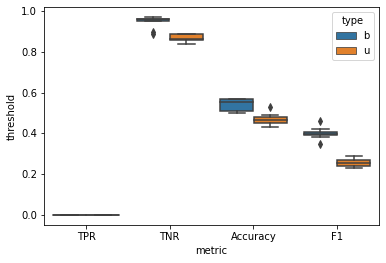

In [15]:
sns.boxplot(x='metric', y='threshold', hue='type', data=bests_xv)

In [16]:
sel_thresh = bests_xv[(bests_xv.metric == 'F1') & (bests_xv.type == 'b')].threshold.mean()

In [17]:
sel_thresh

0.399

## Investigate weights

In [18]:
#W = pd.DataFrame(list(zip(sel_taxa, *[w for r in xvb for w in r[2]])),
#                 columns=['taxon_id']+[ 'r%d_f%d' % (r, f) for r in range(nrepeats) for f in range(nfolds) ]).set_index('taxon_id')
#W.to_pickle('analysis/xv_weights.pkl')
W = pd.read_pickle('analysis/xv_weights.pkl')
WD = W.transpose().describe().transpose()
TW = T[T.taxon_id.isin(sel_taxa)].set_index('taxon_id').join(WD)


TW[~(TW[['mean','min','25%','max']] == 0).any(axis=1)].sort_values('mean')

kingdom          phylum               class              order  \
taxon_id                                                                    
t501      Bacteria  Actinobacteria    Actinobacteria_c  Corynebacteriales   
t472      Bacteria  Proteobacteria  Betaproteobacteria       Neisseriales   
t44       Bacteria  Actinobacteria    Actinobacteria_c  Bifidobacteriales   
t280      Bacteria      Firmicutes             Bacilli    Lactobacillales   
t352      Bacteria  Proteobacteria  Betaproteobacteria    Burkholderiales   
t567      Bacteria    Fusobacteria      Fusobacteria_c    Fusobacteriales   
t70       Bacteria     Tenericutes          Mollicutes    Mycoplasmatales   
t12       Bacteria      Firmicutes             Bacilli    Lactobacillales   
t326      Bacteria      Firmicutes       Negativicutes     Veillonellales   
t544      Bacteria      Firmicutes       Negativicutes     Veillonellales   
t336      Bacteria      Firmicutes             Bacilli         Bacillales   
t24       Bacteria      Firmicutes             Bacilli         Bacillales   

                       family           genus  count      mean       std  \
taxon_id                                                                   
t501               CP009312_f      CP009312_g  100.0 -0.169317  0.029343   
t472            Neisseriaceae      FM873692_g  100.0 -0.113153  0.031657   
t44        Bifidobacteriaceae   Alloscardovia  100.0 -0.072885  0.029577   
t280            Aerococcaceae       Facklamia  100.0 -0.071356  0.020341   
t352           Sutterellaceae      Sutterella  100.0 -0.011318  0.019275   
t567         Fusobacteriaceae   Fusobacterium  100.0 -0.005520  0.009794   
t70       Mycoplasmataceae_f1      Ureaplasma  100.0  0.041177  0.011203   
t12          Streptococcaceae   Streptococcus  100.0  0.072071  0.016318   
t326          Veillonellaceae     Veillonella  100.0  0.075398  0.016785   
t544          Veillonellaceae  Negativicoccus  100.0  0.078175  0.031821   
t336                Gemella_f         Gemella  100.0  0.120714  0.023223   
t24         Staphylococcaceae  Staphylococcus  100.0  0.161634  0.021446   

               min       25%       50%       75%       max  
taxon_id                                                    
t501     -0.231612 -0.193089 -0.166416 -0.147892 -0.108739  
t472     -0.200367 -0.135018 -0.116207 -0.090161 -0.031142  
t44      -0.140775 -0.095433 -0.071522 -0.051290 -0.009688  
t280     -0.116506 -0.085856 -0.073051 -0.057429 -0.024575  
t352     -0.086106 -0.016276 -0.000454  0.000000  0.039625  
t567     -0.031023 -0.011380  0.000000  0.000000  0.015472  
t70       0.015784  0.036287  0.042183  0.047624  0.074735  
t12       0.044646  0.060758  0.069669  0.081636  0.113230  
t326      0.039274  0.063778  0.075093  0.087701  0.110854  
t544      0.010832  0.055160  0.071638  0.100212  0.168975  
t336      0.072218  0.101974  0.120482  0.141333  0.165205  
t24       0.104340  0.149851  0.161912  0.176433  0.199093

# Histogram of prediction densities per label

## TODO: Make figure with different colours

In [19]:
def plot_pred_densities(data,  yvar, predcol, thresh, ax=None):
    if ax is None:
        fig, axes = biu.utils.figure.subplots(ncols=1, figsize=(5,4))
        ax = axes[0]
    #fi
    data = data[data[predcol]>=0]
    values, bins = np.histogram(data[predcol], bins=50)
    _ = ax.hist(data[data[yvar] == 0][predcol], density=True, color=blue, alpha=0.8, bins=bins)
    ax.set_title('Negative labels')
    ax.set_xlabel('Prediction')
    ax.set_ylabel('Density')

    _ = ax.hist(data[data[yvar] == 1][predcol], density=True, color=pink, alpha=0.8, bins=bins)


    xlim = axes[0].get_xlim()
    ylim = axes[0].get_ylim()

    plt.plot([thresh, thresh], ylim, 'gray', linewidth=1, linestyle='dashed')
    axes[0].set_ylim(ylim)

    #fig.savefig(biu.utils.fs.filename_today('/home/thies/repos/UA_underwear/paper_figures/isala_prediction_density','svg'))


#edef

#plot_pred_densities(SA_isala, 'intercourse', 'xv.10.b.7_preds', sel_thresh)

from ipywidgets import interact, interactive, fixed, interact_manual, widgets
interact(lambda feat, thresh: plot_pred_densities(XV_isala, 'intercourse', feat, thresh),
        feat=sorted([x for x in XV_isala.columns if '_preds' in x]),
        thresh = widgets.FloatSlider(value=sel_thresh, min=0, max=1, step=0.01))

# xv.10.b.0_folds 	xv.10.b.0_preds

interactive(children=(Dropdown(description='feat', options=('xv.10.b.0_preds', 'xv.10.b.1_preds', 'xv.10.b.2_p…

<function __main__.<lambda>(feat, thresh)>

# ROC & PROC

In [20]:
def roc_curve(label, preds, ax=None, positive_label=1):
             # tp, fp, oc_thresh
    N = sum(np.array(label) != positive_label)
    T = sum(np.array(label) == positive_label)
    roc = [(0,0,1)]

    for l,p in sorted(zip(label, preds), key=lambda x: x[1], reverse=True):
        tp = roc[-1][0] + (l == positive_label)
        fp = roc[-1][1] + (l != positive_label)
        nv = (tp, fp, p)
        
        if p == roc[-1][2]:
            roc[-1] = nv
        else:
            roc.append(nv)
        #fi
    #efor
    roc.append((T,N+T,0))

    tp, fp, oc_thresh = zip(*roc)
    tpr = np.array(tp) / T
    fpr = np.array(fp) / (T+N)
    
    return list(zip(tpr, fpr, oc_thresh))[::-1]
#edef

def proc_curve(label, preds, ax=None, positive_label=1):
             # tp, fp, oc_thresh
    N = sum(np.array(label) != positive_label)
    T = sum(np.array(label) == positive_label)
    roc = [(0,0,1)]

    for l,p in sorted(zip(label, preds), key=lambda x: x[1], reverse=True):
        tp = roc[-1][0] + (l == positive_label)
        tot = roc[-1][1] + 1
        nv = (tp, tot, p)
        
        if p == roc[-1][2]:
            roc[-1] = nv
        else:
            roc.append(nv)
        #fi
    #efor
    roc.append((T,N+T,0))

    tp, tot, oc_thresh = zip(*roc)
    tpr = np.array(tp) / T
    precision = (1+np.array(tp)) / (1+np.array(tot))
    
    return list(zip(tpr, precision, oc_thresh))[::-1][:-1] + [(0,1,1)]
#edef

def auroc(roc, *args):
    A = 0
    tp, fp, oc_thresh = zip(*roc)
    for i in range(len(tp))[1:]:
        A += ( tp[i]*(fp[i]-fp[i-1]))
    #efor
    return -A
#edef

def auproc(proc, *args):
    A = 0
    recall, precision, oc_thresh = zip(*proc)
    for i in range(len(recall))[1:]:
        A += ( precision[i]*(recall[i]-recall[i-1]))
    #efor
    return -A
#edef

def sig_auproc(label, preds, n=1000, *pargs):
    shl = [ label ]
    sh = np.array(label).copy()
    for i in range(n):
        np.random.shuffle(sh)
        shl.append(sh.copy())
    #efor

    aucs = np.array([ auproc(proc_curve(l, preds)) for l in shl ])
    
    return aucs, (sum(aucs >= aucs[0])) / (n)
#edef

def sig_auroc(label, preds, n=1000, *pargs):
    shl = [ label ]
    sh = np.array(label).copy()
    for i in range(n):
        np.random.shuffle(sh)
        shl.append(sh.copy())
    #efor

    aucs = np.array([ auroc(roc_curve(l, preds)) for l in shl ])
    
    return aucs, (sum(aucs >= aucs[0])) / (n)
#edef

10/10

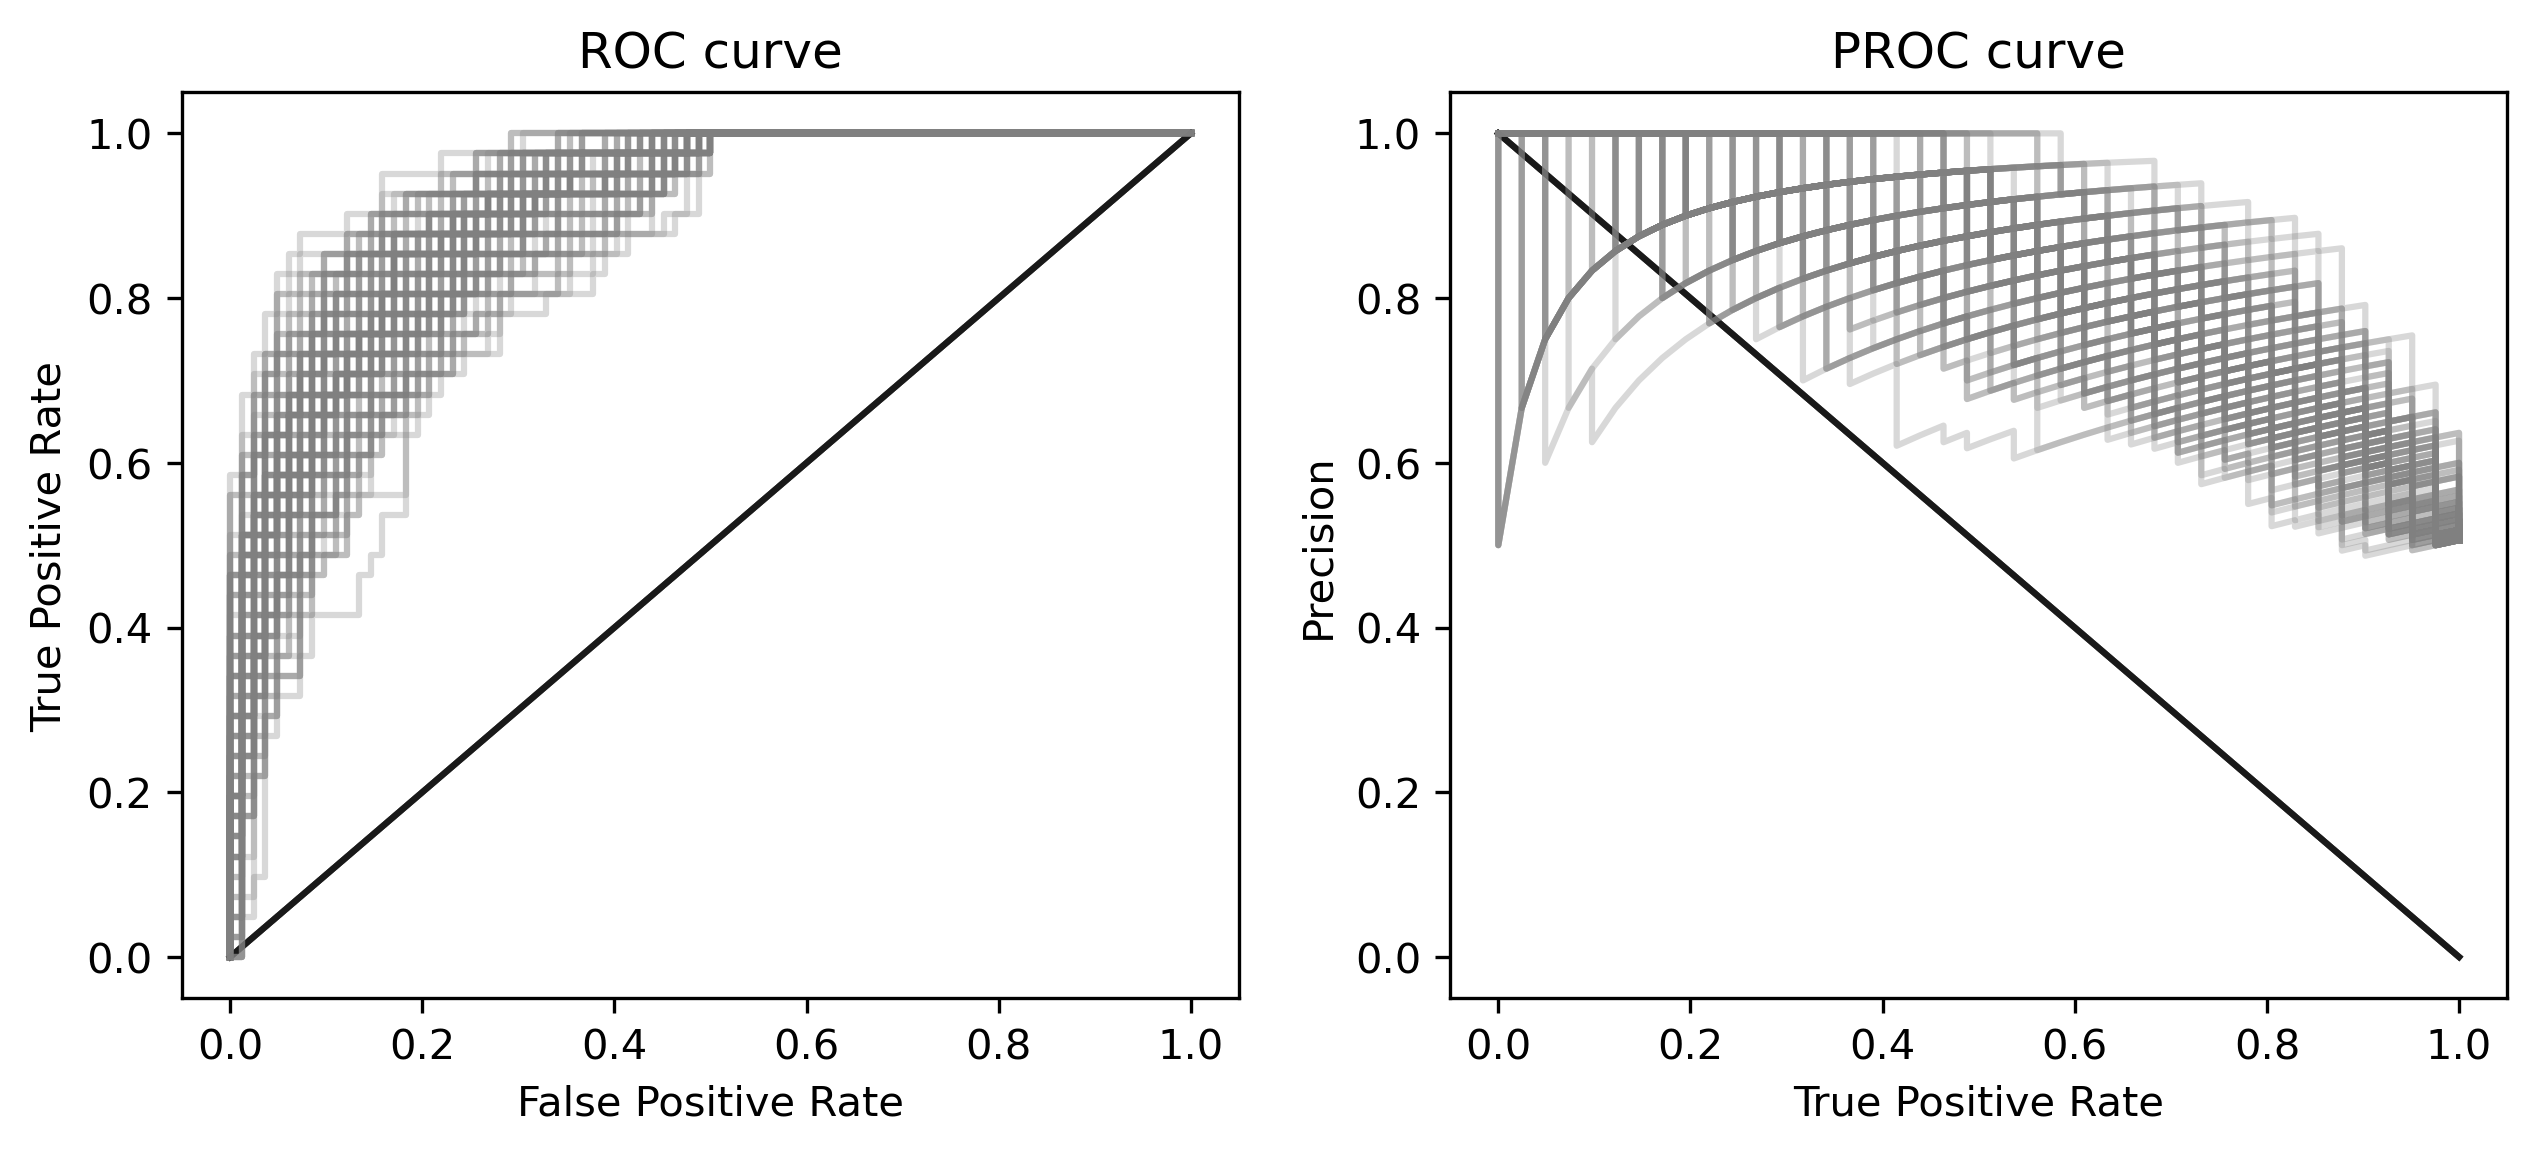

In [21]:
def plot_roc(data,  yvar, predcol, foldcol, ax1=None, ax2=None, **kwargs):
    if ax1 is None:
        fig, axes = biu.utils.figure.subplots(ncols=2, figsize=(10,4))
        ax1 = axes[0]
        ax2 = axes[1]

    roc_sig = []
    proc_sig = []
    nfolds = len(data[data[foldcol] >= 0][foldcol].unique())
    for fold in range(nfolds):
        print("\r%d/%d" % (fold+1, nfolds), end="")
        l = data[yvar][data[foldcol] == fold]
        p = data[predcol][data[foldcol] == fold]

        roc = roc_curve(l, p)
        tpr, fpr, oc_thresh = zip(*roc)
        #roc_sig.append(sig_auroc(l, p))
        ax1.plot(fpr, tpr, **kwargs)

        proc = proc_curve(l, p)
        recall, precision, oc_thresh = zip(*proc)
        #proc_sig.append(sig_auproc(l, p))
        ax2.plot(recall, precision, **kwargs)
    #efor

    ax1.plot([0,1],[0,1], '-', c='k', zorder=-1, alpha=0.2)
    ax1.set_title('ROC curve')
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')

    ax2.set_title('PROC curve')
    ax2.plot([0,1],[1,0], '-', c='k', zorder=-1, alpha=0.2)
    ax2.set_ylabel('Precision')
    ax2.set_xlabel('True Positive Rate')
#edef

fig, axes = biu.utils.figure.subplots(ncols=2, figsize=(10,4))
for r in range(nrepeats):
    plot_roc(XV_isala, "intercourse", "xv.10.b.%d_preds" % r, 'xv.10.b.%d_folds' %r, ax1=axes[0], ax2=axes[1], c='gray', alpha=0.3)
#efor


## Calculate Average AUC across all the repeated XVs

In [22]:
aucs = []
for r in range(nrepeats):
    #plot_roc(SA_isala, "intercourse", "xv.10.b.%d_preds" % r, 'xv.10.b.%d_folds' %r, ax1=axes[0], ax2=axes[1], c='gray', alpha=0.3)
    foldcol = 'xv.10.b.%d_folds' %r
    predcol = 'xv.10.b.%d_preds' %r
    yvar = "intercourse"
    data = XV_isala
    nfolds = len(data[data[foldcol] >= 0][foldcol].unique())
    
    
    aucperm, aucperm_p   = sig_auroc(data[data[foldcol] >= 0][yvar], data[data[foldcol] >= 0][predcol])
    auprperm, auprperm_p = sig_auproc(data[data[foldcol] >= 0][yvar], data[data[foldcol] >= 0][predcol])
    for a in aucperm[1:]:
        aucs.append((r, -1, "AUC ROC", "Permuted", a))
    #efor
    
    for a in auprperm[1:]:
        aucs.append((r, -1, "AUC PR", "Permuted", a))
    #efor
    
    for fold in range(nfolds):
    
        l = data[yvar][data[foldcol] == fold]
        p = data[predcol][data[foldcol] == fold]
        aucs.append((r, fold, "AUC ROC", "Crossvalidation", auroc(roc_curve(l, p))))
        aucs.append((r, fold, "AUC PR",  "Crossvalidation", auproc(proc_curve(l, p))))
    #efor
#efor
aucs = pd.DataFrame(aucs, columns=["repeat", "fold", 'type', 'source', "AUC"])

0.601

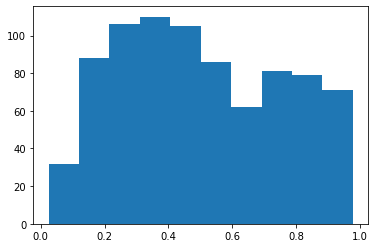

In [23]:
plt.hist([ x for x in XV_isala['xv.10.b.0_preds'] if x >= 0])
1-0.399

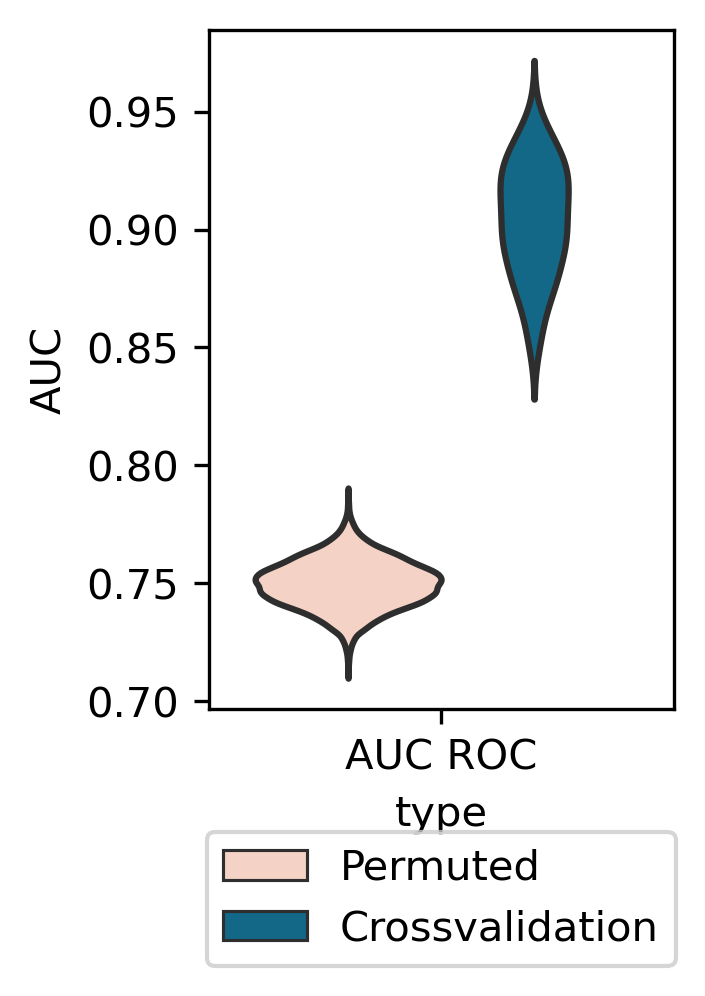

In [37]:
fig, axes = biu.utils.figure.subplots(ncols=1, figsize=(2,3))

sns.violinplot(x='type', y="AUC", hue="source", palette=[pink,blue], data=aucs[aucs['type']=='AUC ROC'], ax=axes[0], inner=None)
axes[0].legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=1)

fig.savefig(biu.utils.fs.filename_today('/home/thies/repos/UA_underwear/paper_figures/isala_prediction','svg'))

# Full model

In [25]:
XV_isala

participant  intercourse  xv.10.b.0_folds  xv.10.b.0_preds  \
sample_id                                                              
s202       ISALA01033            0             -1.0        -1.000000   
s203       ISALA01040            0             -1.0        -1.000000   
s204       ISALA01061            0              5.0         0.837077   
s205       ISALA01086            0             -1.0        -1.000000   
s206       ISALA01107            0             -1.0        -1.000000   
...               ...          ...              ...              ...   
s2987      ISALA06028            0             -1.0        -1.000000   
s2988      ISALA00047            0             -1.0        -1.000000   
s2989      ISALA00064            0             -1.0        -1.000000   
s2990      ISALA01042            0             -1.0        -1.000000   
s2991      ISALA06034            0             -1.0        -1.000000   

           xv.10.b.1_folds  xv.10.b.1_preds  xv.10.b.2_folds  xv.10.b.2_preds  \
sample_id                                                                       
s202                  -1.0        -1.000000              6.0         0.370159   
s203                  -1.0        -1.000000             -1.0        -1.000000   
s204                  -1.0        -1.000000             -1.0        -1.000000   
s205                  -1.0        -1.000000             -1.0        -1.000000   
s206                  -1.0        -1.000000             -1.0        -1.000000   
...                    ...              ...              ...              ...   
s2987                 -1.0        -1.000000             -1.0        -1.000000   
s2988                 -1.0        -1.000000             -1.0        -1.000000   
s2989                  7.0         0.265396              4.0         0.181136   
s2990                  5.0         0.506231             -1.0        -1.000000   
s2991                 -1.0        -1.000000              0.0         0.525630   

           xv.10.b.3_folds  xv.10.b.3_preds  ...  xv.10.u.5_folds  \
sample_id                                    ...                    
s202                  -1.0        -1.000000  ...              9.0   
s203                   4.0         0.573778  ...              7.0   
s204                  -1.0        -1.000000  ...              1.0   
s205                  -1.0        -1.000000  ...              7.0   
s206                   0.0         0.474642  ...              2.0   
...                    ...              ...  ...              ...   
s2987                  6.0         0.461950  ...              1.0   
s2988                 -1.0        -1.000000  ...              0.0   
s2989                  0.0         0.148058  ...              9.0   
s2990                 -1.0        -1.000000  ...              1.0   
s2991                 -1.0        -1.000000  ...              8.0   

           xv.10.u.5_preds  xv.10.u.6_folds  xv.10.u.6_preds  xv.10.u.7_folds  \
sample_id                                                                       
s202              0.069820              3.0         0.072541              5.0   
s203              0.146542              7.0         0.146846              5.0   
s204              0.565603              0.0         0.511198              1.0   
s205              0.018794              6.0         0.017264              6.0   
s206              0.131666              7.0         0.133047              9.0   
...                    ...              ...              ...              ...   
s2987             0.211625              0.0         0.243393              6.0   
s2988             0.230273              8.0         0.224900              2.0   
s2989             0.040472              7.0         0.045135              9.0   
s2990             0.182958              0.0         0.167670              3.0   
s2991             0.089107              6.0         0.134481              2.0   

           xv.10.u.7_preds  xv.10.u.8_folds  xv.10.u.8_preds  xv.10

In [26]:
repeats=XV_isala[[c for c in XV_isala.columns if ('xv.10.b' in c) and ('folds' in c)]] >= 0
SA_isala

participant  intercourse        t1       t10      t100      t101  \
sample_id                                                                    
s202       ISALA01033            0 -7.361713 -7.361713 -7.361713 -7.361713   
s203       ISALA01040            0 -6.361567 -6.361567 -6.361567 -6.361567   
s204       ISALA01061            0 -6.459467 -6.459467 -6.459467 -6.459467   
s205       ISALA01086            0 -7.009669 -7.009669 -7.009669 -7.009669   
s206       ISALA01107            0 -5.664552 -5.664552 -5.664552 -5.664552   
...               ...          ...       ...       ...       ...       ...   
s2987      ISALA06028            0 -6.248412 -6.248412 -6.248412 -6.248412   
s2988      ISALA00047            0 -7.125599 -7.125599 -7.125599 -7.125599   
s2989      ISALA00064            0 -8.458578 -8.458578 -8.458578 -8.458578   
s2990      ISALA01042            0 -5.331726 -5.331726 -5.331726 -5.331726   
s2991      ISALA06034            0 -8.381651 -8.381651 -8.381651 -8.381651   

               t102      t103      t104      t105  ...       t90       t91  \
sample_id                                          ...                       
s202      -7.361713 -7.361713 -7.361713 -7.361713  ... -7.361713 -7.361713   
s203      -6.361567 -6.361567 -6.361567 -6.361567  ... -6.361567 -6.361567   
s204      -6.459467 -6.459467 -6.459467 -6.459467  ... -6.459467 -6.459467   
s205      -7.009669 -7.009669 -7.009669 -7.009669  ... -7.009669 -7.009669   
s206      -5.664552 -5.664552 -5.664552 -5.664552  ... -5.664552 -5.664552   
...             ...       ...       ...       ...  ...       ...       ...   
s2987     -6.248412 -6.248412 -6.248412 -6.248412  ... -6.248412 -6.248412   
s2988     -7.125599 -7.125599 -7.125599 -7.125599  ... -7.125599 -7.125599   
s2989     -8.458578 -8.458578 -8.458578 -8.458578  ... -8.458578 -8.458578   
s2990     -5.331726 -5.331726 -5.331726 -5.331726  ... -5.331726 -5.331726   
s2991     -8.381651 -8.381651 -8.381651 -8.381651  ... -8.381651 -8.381651   

                t92       t93       t94       t95       t96       t97  \
sample_id                                                               
s202      -7.361713 -7.361713 -7.361713 -7.361713 -7.361713 -7.361713   
s203      -6.361567 -6.361567 -6.361567 -6.361567 -6.361567 -6.361567   
s204      -6.459467 -6.459467 -6.459467 -6.459467 -6.459467 -6.459467   
s205      -7.009669 -7.009669 -7.009669 -7.009669 -7.009669 -7.009669   
s206      -5.664552 -5.664552 -5.664552 -5.664552 -5.664552 -5.664552   
...             ...       ...       ...       ...       ...       ...   
s2987     -6.248412 -6.248412 -6.248412 -6.248412 -6.248412 -6.248412   
s2988     -7.125599 -7.125599 -7.125599 -7.125599 -7.125599 -7.125599   
s2989     -8.458578 -8.458578 -8.458578 -8.458578 -8.458578 -8.458578   
s2990     -5.331726 -5.331726 -5.331726 -5.331726 -5.331726 -5.331726   
s2991     -8.381651 -8.381651 -8.381651 -8.381651 -8.381651 -8.381651   

                t98       t99  
sample_id                      
s202      -7.361713 -7.361713  
s203      -6.361567 -6.361567  
s204      -6.459467 -6.459467  
s205      -7.009669 -7.009669  
s206      -5.664552 -5.664552  
...             ...       ...  
s2987     -6.248412 -6.248412  
s2988     -7.125599 -7.125599  
s2989     -8.458578 -8.458578  
s2990     -5.331726 -5.331726  
s2991     -8.381651 -8.381651  

[2790 rows x 629 columns]

In [27]:
R("""
library(glmnet)
    full.models <- lapply(colnames(repeats), function(r){
        model <- cv.glmnet(as.matrix(data[repeats[,r],sel_taxa]), family='binomial',
                           data[repeats[,r],yvar], alpha=0.5)
    })
""", push=dict(repeats=XV_isala[[c for c in XV_isala.columns if ('xv.10.b' in c) and ('folds' in c)]] >= 0,
           data=SA_isala, 
           sel_taxa=sel_taxa,
           yvar=yvar))

R[write to console]: Loading required package: Matrix

R[write to console]: 
Attaching package: ‘Matrix’


R[write to console]: The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


R[write to console]: Loaded glmnet 4.1-1



## Investigate weights in the full model

In [28]:
#FMW = R("""
#    full.models.W <- as.data.frame(lapply(full.models, function(m){
#        as.vector(coef(m, s=model$lambda.min))
#        }))
#    colnames(full.models.W) <- 1:10
#    full.models.W
#""")
#
#
#FMW = FMW.iloc[1:]
#FMW['taxon_id'] = sel_taxa
#FMW.to_pickle('analysis/full_model_weights.pkl')
FMW = pd.read_pickle('analysis/full_model_weights.pkl')

TW = T.set_index('taxon_id').loc[sel_taxa].join(FMW.set_index('taxon_id'))[ ['genus'] + [str(x) for x in range(1,11)]].set_index('genus')

TW.transpose().describe().transpose().sort_values('mean').to_excel('analysis/full_model_weight_stats.xlsx')
#TW[TW.weight.abs() > 0].sort_values('weight')
 
TW.transpose().describe().transpose().sort_values('mean')

#CP009312 : Bacteria;Actinobacteria;Actinomycetia;Mycobacteriales;Lawsonellaceae;Lawsonella;Lawsonella clevelandensis;CP009312 
#FM873692 : Bacteria;Proteobacteria;Betaproteobacteria;Neisseriales;Neisseriaceae;FM873692_g;FM873692_s;FM873692 

count      mean       std       min       25%  \
genus                                                                          
CP009312_g                      10.0 -0.211348  0.029123 -0.258024 -0.228724   
FM873692_g                      10.0 -0.145755  0.029057 -0.186145 -0.169167   
Facklamia                       10.0 -0.106711  0.018825 -0.129429 -0.120716   
Alloscardovia                   10.0 -0.100242  0.029931 -0.142254 -0.117275   
Parvimonas                      10.0 -0.072862  0.039655 -0.135257 -0.095195   
Dialister                       10.0 -0.044359  0.030046 -0.096390 -0.066752   
Atopobium                       10.0 -0.038878  0.019706 -0.071963 -0.050417   
Lactobacillus crispatus group   10.0 -0.029814  0.012519 -0.056006 -0.032292   
Anaerococcus                    10.0 -0.024091  0.016454 -0.048939 -0.039441   
Sutterella                      10.0 -0.021449  0.025770 -0.068115 -0.034018   
Ezakiella                       10.0 -0.018121  0.019383 -0.056742 -0.027772   
Fusobacterium                   10.0 -0.011107  0.016832 -0.039528 -0.022618   
NaN                             10.0 -0.010131  0.046378 -0.092443 -0.036670   
Murdochiella                    10.0 -0.010026  0.013902 -0.041604 -0.015599   
Prevotella                      10.0 -0.009355  0.027786 -0.083091 -0.005235   
Bifidobacterium                 10.0 -0.006459  0.015602 -0.047066 -0.005486   
Moryella                        10.0 -0.005160  0.008307 -0.025765 -0.008190   
Olsenella                       10.0 -0.003547  0.023795 -0.052060 -0.004673   
Gardnerella                     10.0 -0.002673  0.004950 -0.014557 -0.004394   
Actinotignum                    10.0 -0.001656  0.018132 -0.044118 -0.001482   
Peptococcus                     10.0  0.002204  0.015170 -0.025727  0.000000   
Peptostreptococcus              10.0  0.003145  0.009573 -0.014477  0.000153   
Limosilactobacillus             10.0  0.005924  0.014651 -0.018255  0.000000   
Finegoldia                      10.0  0.008500  0.026540 -0.050253  0.000000   
Campylobacter                   10.0  0.008549  0.016553 -0.005585  0.000000   
Clostridium                     10.0  0.010722  0.014177 -0.008137  0.000000   
Megasphaera                     10.0  0.018973  0.016444 -0.007116  0.010329   
Sneathia                        10.0  0.021583  0.023023  0.000000  0.006066   
Fenollaria                      10.0  0.023850  0.017881  0.000526  0.015115   
Peptoniphilus                   10.0  0.028424  0.023887  0.000000  0.012014   
Aerococcus                      10.0  0.029780  0.020554  0.000021  0.013615   
JN713389_g                      10.0  0.034792  0.023855  0.000000  0.018690   
Porphyromonas                   10.0  0.044623  0.025001  0.000000  0.027567   
Corynebacterium                 10.0  0.047515  0.024336  0.012567  0.030234   
Howardella                      10.0  0.048709  0.024203  0.000000  0.036519   
Mobiluncus                      10.0  0.050865  0.033584  0.006599  0.028939   
Ureaplasma                      10.0  0.056130  0.008926  0.036134  0.054164   
Actinomyces                     10.0  0.072245  0.029727  0.043607  0.045455   
Streptococcus                   10.0  0.080507  0.017006  0.061527  0.068729   
Veillonella                     10.0  0.085061  0.017968  0.058226  0.072984   
Negativicoccus                  10.0  0.097192  0.030903  0.061582  0.071922   
Gemella                         10.0  0.134150  0.026571  0.092750  0.119872   
Staphylococcus                  10.0  0.174115  0.022464  0.126160  0.162753   

                                    50%       75%       max  
genus                                                        
CP009312_g                    -0.205880 -0.189034 -0.170780  
FM873692_g                    -0.142839 -0.133004 -0.093371  
Facklamia                     -0.110742 -0.092661 -0.078829  
Alloscardovia                 -0.097937 -0.082971 -0.055876  
Parvimonas                    -0.068046 -0.038736 -0.02462

## GeneDoe

In [29]:
genedoe_preds = R("""
preds = as.data.frame(lapply(full.models, function(m){
    predict(m, as.matrix(testx), type="response", s=m$lambda.min)
    }))

#colnames(preds) = 1:10

preds
""", push=dict(testx=SA_genedoe[sel_taxa],
               testy=SA_genedoe['intercourse']))

interactive(children=(Dropdown(description='r', options=('X1', 'X1.1', 'X1.2', 'X1.3', 'X1.4', 'X1.5', 'X1.6',…

WilcoxonResult(statistic=0.0, pvalue=0.001953125)


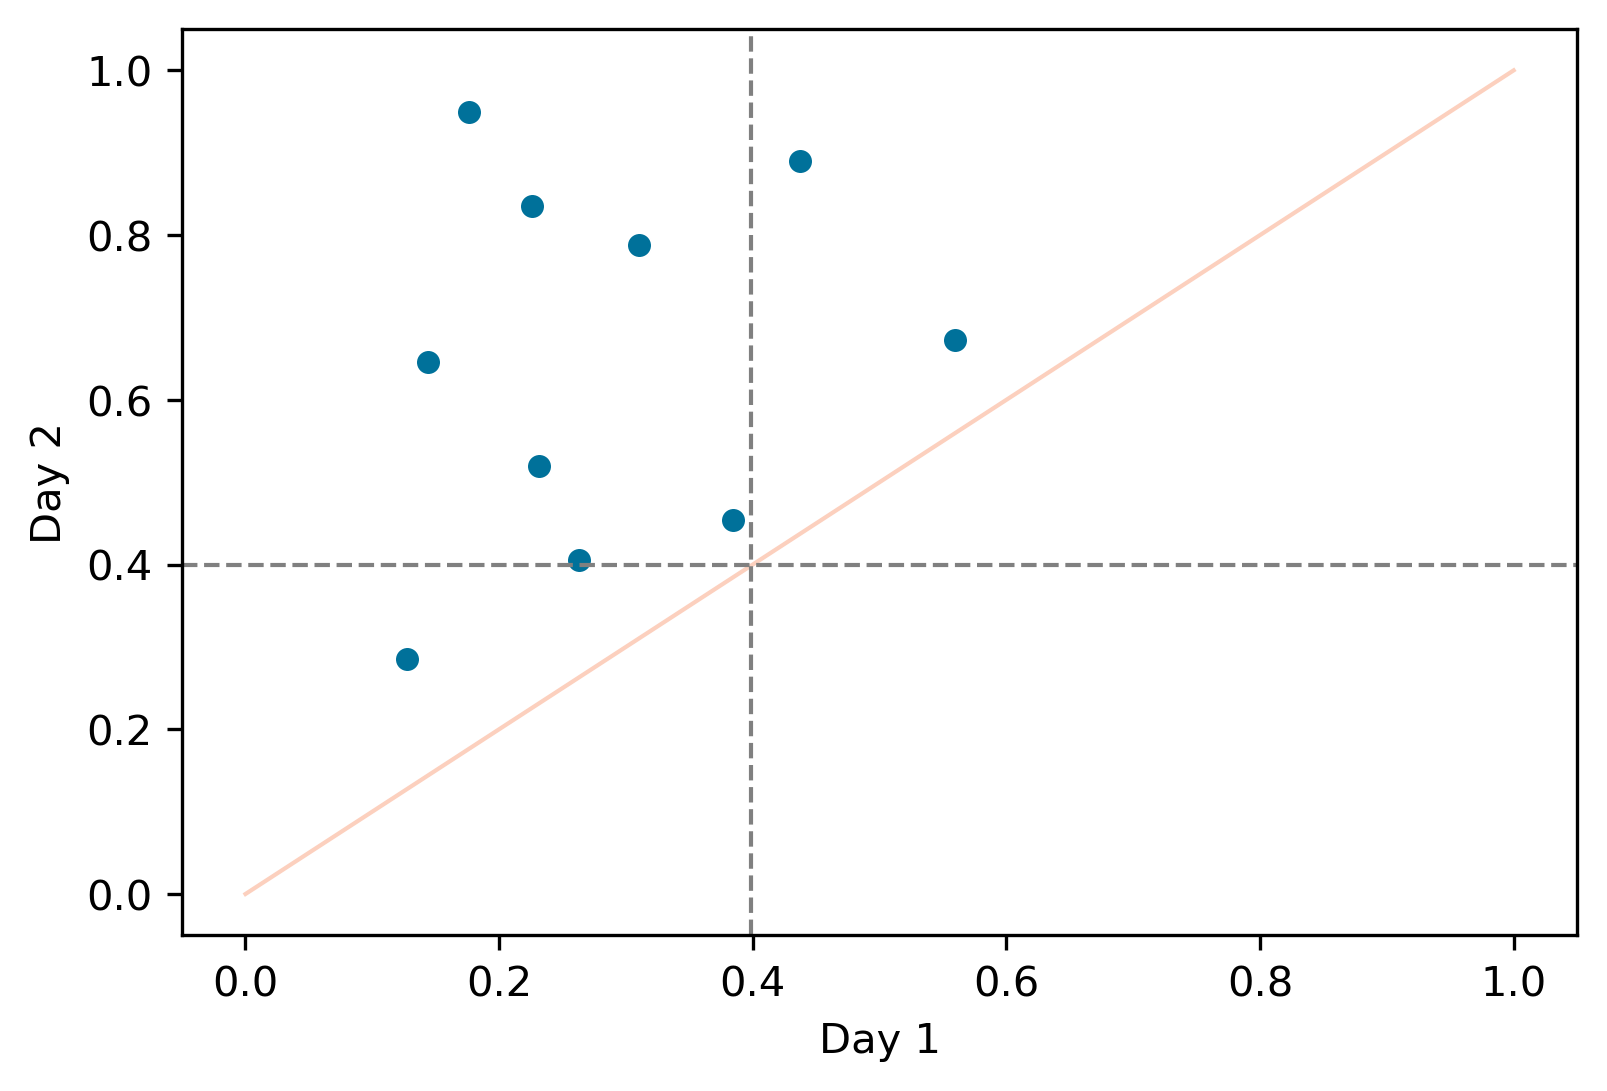

In [64]:
#res = R("""
#    library(glmnet)
#    t <- predict(full.model, as.matrix(testx), type="response", s=full.model$lambda.min)
#    t
#    """, push=dict(testx=SA_genedoe[sel_taxa],
#                   testy=SA_genedoe['intercourse']))


def plot_genedoe_results(r):

    gdr = SA_genedoe.copy()
    if r == 'mean':
        gdr['prediction'] = genedoe_preds.mean(axis=1)
    else:
        gdr['prediction'] = genedoe_preds[r]
    #fi

    gp = gdr[['participant','explanation','prediction']].pivot(index='participant', columns='explanation', values='prediction')

    fig, axes = biu.utils.figure.subplots()
    sns.scatterplot(x=gp['Day 1'], y=gp['Day 2'], ax=axes[0], color=blue)
    axes[0].plot([0,1],[0,1], c=pink, linewidth=1)
    
    print(scipy.stats.wilcoxon(gp['Day 1'], gp['Day 2']))

    xlim = axes[0].get_xlim()
    ylim = axes[0].get_ylim()

    plt.plot([sel_thresh, sel_thresh], ylim, 'gray', linewidth=1, linestyle='dashed')
    plt.plot(xlim, [sel_thresh, sel_thresh], 'gray', linewidth=1, linestyle='dashed')

    axes[0].set_ylim(ylim)
    axes[0].set_xlim(xlim)
    return fig, gp
#edef

from ipywidgets import interact, interactive, fixed, interact_manual, widgets
interact(lambda r: plot_genedoe_results(r),
        r=list(genedoe_preds.columns) + ['mean'])

fig, gp = plot_genedoe_results('mean')
fig.savefig(biu.utils.fs.filename_today('/home/thies/repos/UA_underwear/paper_figures/genedoe_prediction','svg'))

In [32]:
genedoe_preds.mean(axis=1)

s132    0.231137
s133    0.418219
s134    0.196344
s135    0.289573
s136    0.564201
          ...   
s197    0.152106
s198    0.269024
s199    0.869007
s200    0.405960
s201    0.514570
Length: 70, dtype: float64

In [33]:
SA_genedoe[['participant', 'explanation']].join(genedoe_preds).pivot
SA_genedoe['avg_preds'] = (genedoe_preds > sel_thresh).sum(axis=1)
SA_genedoe.pivot(index="participant", columns="explanation", values='avg_preds')
#SA_genedoe

explanation  Day 1  Day 2  Day 3  Day 4  Day 5  Day 6  Day 7
participant                                                 
1                0     10      6      0      0     10     10
10               0     10     10      4      2      9     10
11               0      0      1      0      0      0      3
2               10     10     10      0      0      0      0
4                4     10      0      0      0     10      0
5                7     10     10     10      6     10     10
6                0     10     10      0      0      0     10
7                0     10      0      0      0      1      0
8                0     10      0      0      0     10      0
9                0      5      0      0      0     10     10

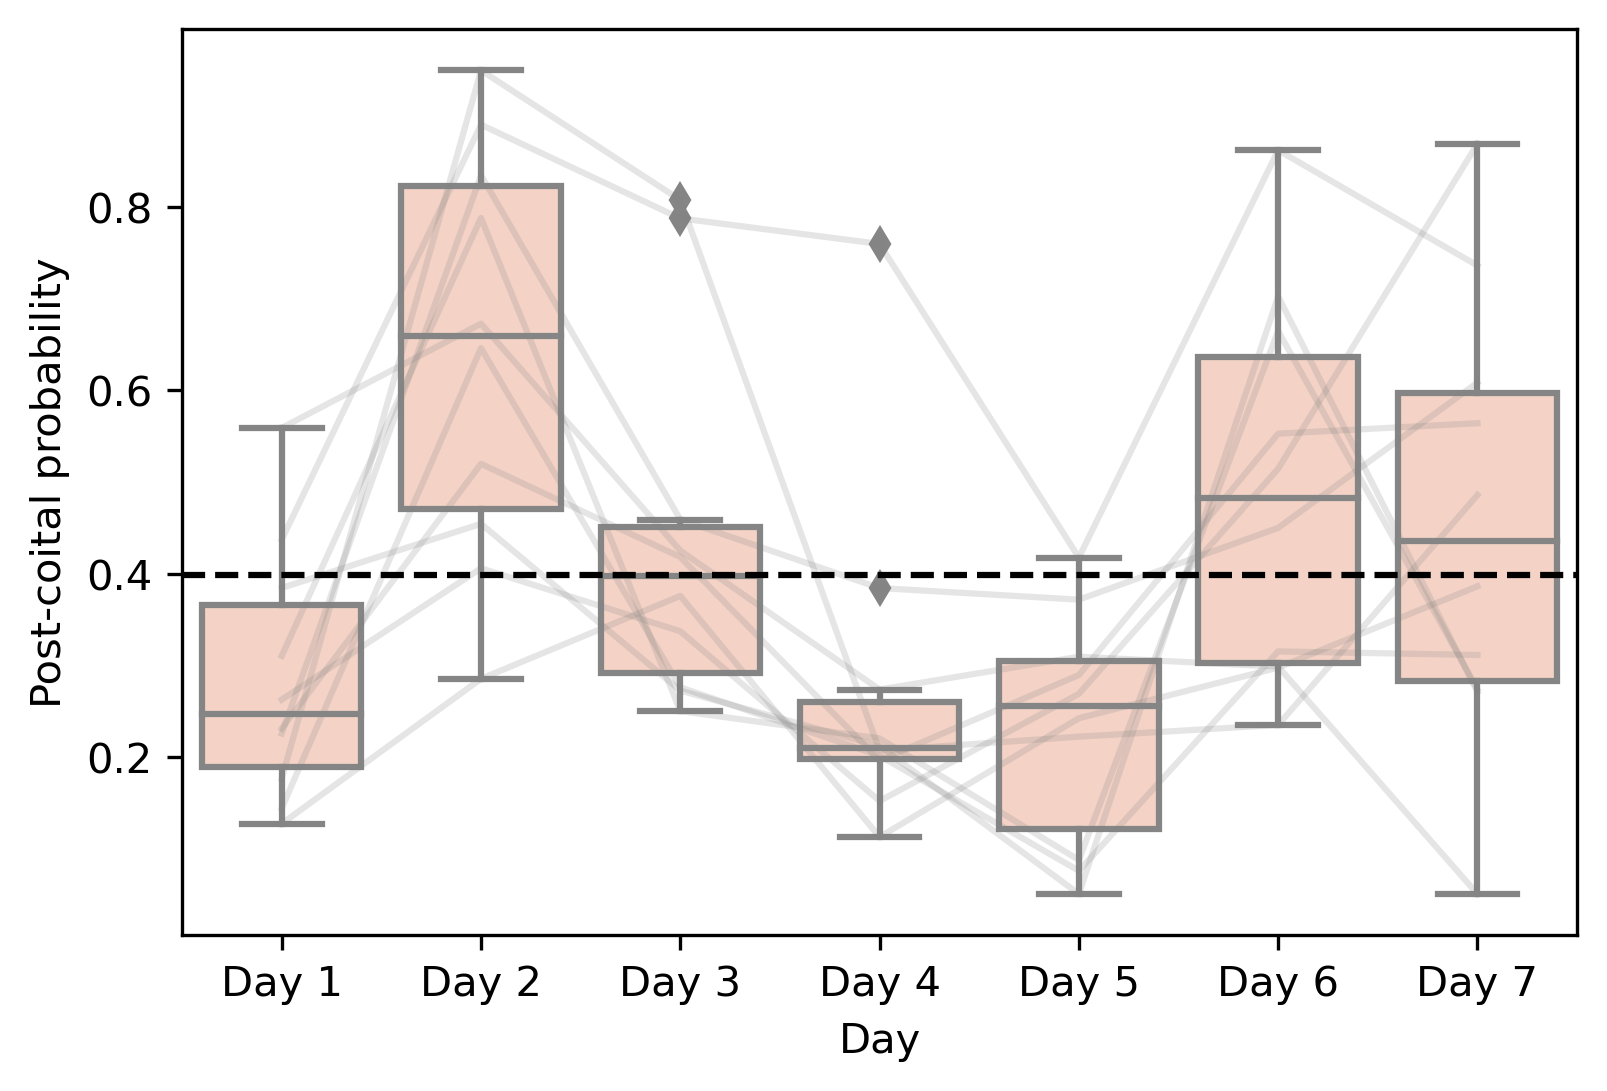

In [36]:
def plot_genedoe_heatmap(r):

    #fig, axes = biu.utils.figure.subplots()

    gdr = SA_genedoe.copy()
    if r == 'mean':
        gdr['prediction'] = genedoe_preds.mean(axis=1)
    else:
        gdr['prediction'] = genedoe_preds[r]
    #fi
    
    gdr.participant = gdr.participant.apply(lambda x: 3 if x == '11' else int(x))

    gp = gdr[['participant','explanation','prediction']].pivot(index='participant', columns='explanation', values='prediction')
    
    
    sns.heatmap(gp, cmap=bluepink_cmap, center=sel_thresh, vmin=0, vmax=1, ax=axes[0],
                fmt="s", annot=gp.applymap(lambda x: '*' if x >= sel_thresh else ''))
    fig.axes[-1].plot([0,1], [sel_thresh, sel_thresh], 'k')
    return fig
#edef

def plot_genedoe_boxplots(r, sel_thresh=sel_thresh):

    fig, axes = biu.utils.figure.subplots()

    gdr = SA_genedoe.copy()
    if r == 'mean':
        gdr['prediction'] = genedoe_preds.mean(axis=1)
    else:
        gdr['prediction'] = genedoe_preds[r]
    #fi
    
    gdr.participant = gdr.participant.apply(lambda x: 3 if x == '11' else int(x))

    gp = gdr[['participant','explanation','prediction']].pivot(index='participant', columns='explanation', values='prediction')
    
    sns.boxplot(x='explanation', y='value', data=gp.melt(), ax=axes[0], color=pink)
    gp.transpose().plot(c='gray', alpha=0.2, ax=axes[0], legend=False)

    xlim = axes[0].get_xlim()
    fig.axes[-1].plot(xlim, [sel_thresh, sel_thresh], 'k--', zorder=4)
    axes[0].set_xlim(xlim)
    axes[0].set_ylabel('Post-coital probability')
    axes[0].set_xlabel('Day')
    
    return fig
#edef

#from ipywidgets import interact, interactive, fixed, interact_manual, widgets
#interact(lambda r: plot_genedoe_heatmap(r),
#        r=list(genedoe_preds.columns) + ['mean'])


fig = plot_genedoe_boxplots('mean', sel_thresh=sel_thresh)
fig.savefig(biu.utils.fs.filename_today('/home/thies/repos/UA_underwear/paper_figures/genedoe_prediction_days','svg'))




#fig.savefig(biu.utils.fs.filename_today('/home/thies/repos/UA_underwear/paper_figures/genedoe_prediction_days','svg'))
#fig, axes = biu.utils.figure.subplots()
#for p in genedoe_pred.index:
#    axes[0].plot([1,2,3,4,5,6,7], (genedoe_pred.loc[p] - genedoe_pred.loc[p].mean()) / genedoe_pred.loc[p].std())

## Rapekit

In [38]:
rk_datasets = SA_rapekit.dataset.unique()

rapekit_preds = R("""
preds = as.data.frame(lapply(full.models, function(m){
    predict(m, as.matrix(testx), type="response", s=m$lambda.min)
    }))
colnames(preds) = 1:10

preds
""", push=dict(testx=SA_rapekit[sel_taxa]))

interactive(children=(Dropdown(description='r', options=('1', '2', '3', '4', '5', '6', '7', '8', '9', '10', 'm…

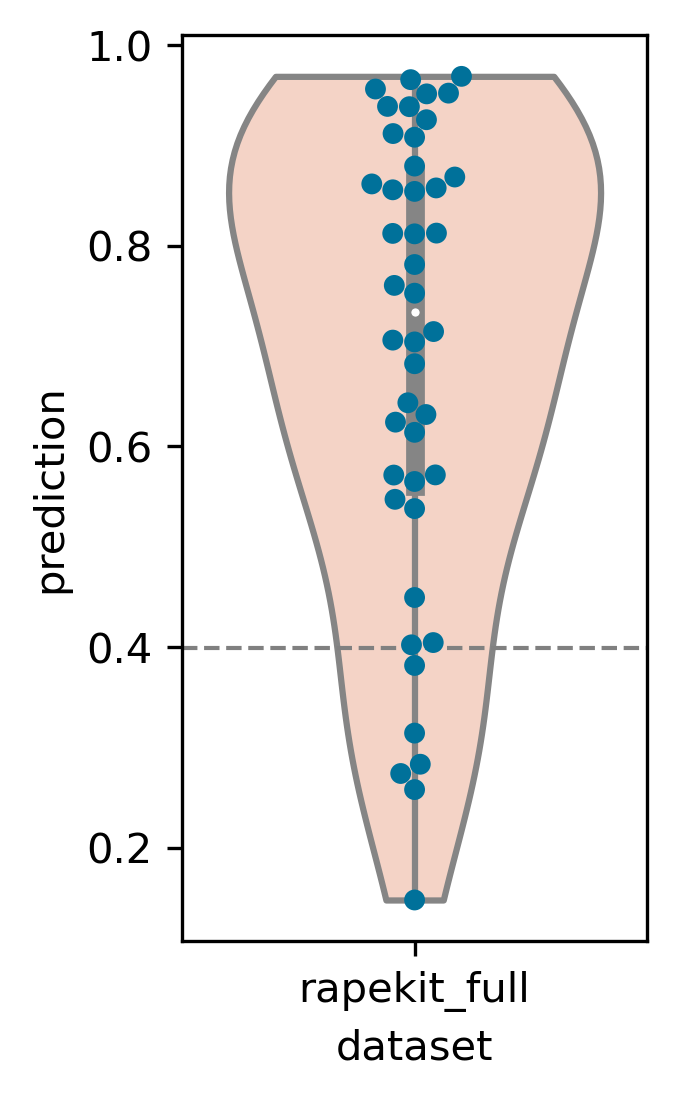

In [62]:

def plot_rapekit_preds(r):
    
    rkp = SA_rapekit.copy()
    if r == 'mean':
        rkp['prediction'] = rapekit_preds.mean(axis=1)
    else:
        rkp['prediction'] = rapekit_preds[r]
    #fi

    fig, axes = biu.utils.figure.subplots(ncols=1, figsize=(2,4))
    sns.violinplot(x='dataset', y='prediction', data=rkp[rkp.dataset == 'rapekit_full'], palette=[pink], cut=0, ax=axes[0])
    sns.swarmplot(x='dataset', y='prediction', data=rkp[rkp.dataset == 'rapekit_full'], color=blue, ax=axes[0])
    #for i, row in SA_rapekit.pivot(index='SAS_number', columns='dataset', values='prediction').iterrows():
    #    plt.plot([0,1,2], row, alpha=0.2, c='k')

    xlim = axes[0].get_xlim()
    ylim = axes[0].get_ylim()

    #plt.plot([sel_thresh, sel_thresh], ylim, 'gray', linewidth=1, linestyle='dashed')
    plt.plot(xlim, [sel_thresh, sel_thresh], 'gray', linewidth=1, linestyle='dashed')

    axes[0].set_ylim(ylim)
    axes[0].set_xlim(xlim)
    return fig
#edef


from ipywidgets import interact, interactive, fixed, interact_manual, widgets
interact(lambda r: plot_rapekit_preds(r),
        r=list(rapekit_preds.columns) + ['mean'])

fig = plot_rapekit_preds('mean')
fig.savefig(biu.utils.fs.filename_today('/home/thies/repos/UA_underwear/paper_figures/rapekit_prediction','svg'))


In [53]:
print(SA_rapekit[SA_rapekit.dataset == 'rapekit_SF'].prediction.mean())
print(SA_rapekit[SA_rapekit.dataset == 'rapekit_VF'].prediction.mean())
print(SA_rapekit[SA_rapekit.dataset == 'rapekit_full'].prediction.mean())

AttributeError: 'DataFrame' object has no attribute 'prediction'

interactive(children=(Dropdown(description='r', options=('1', '2', '3', '4', '5', '6', '7', '8', '9', '10', 'm…

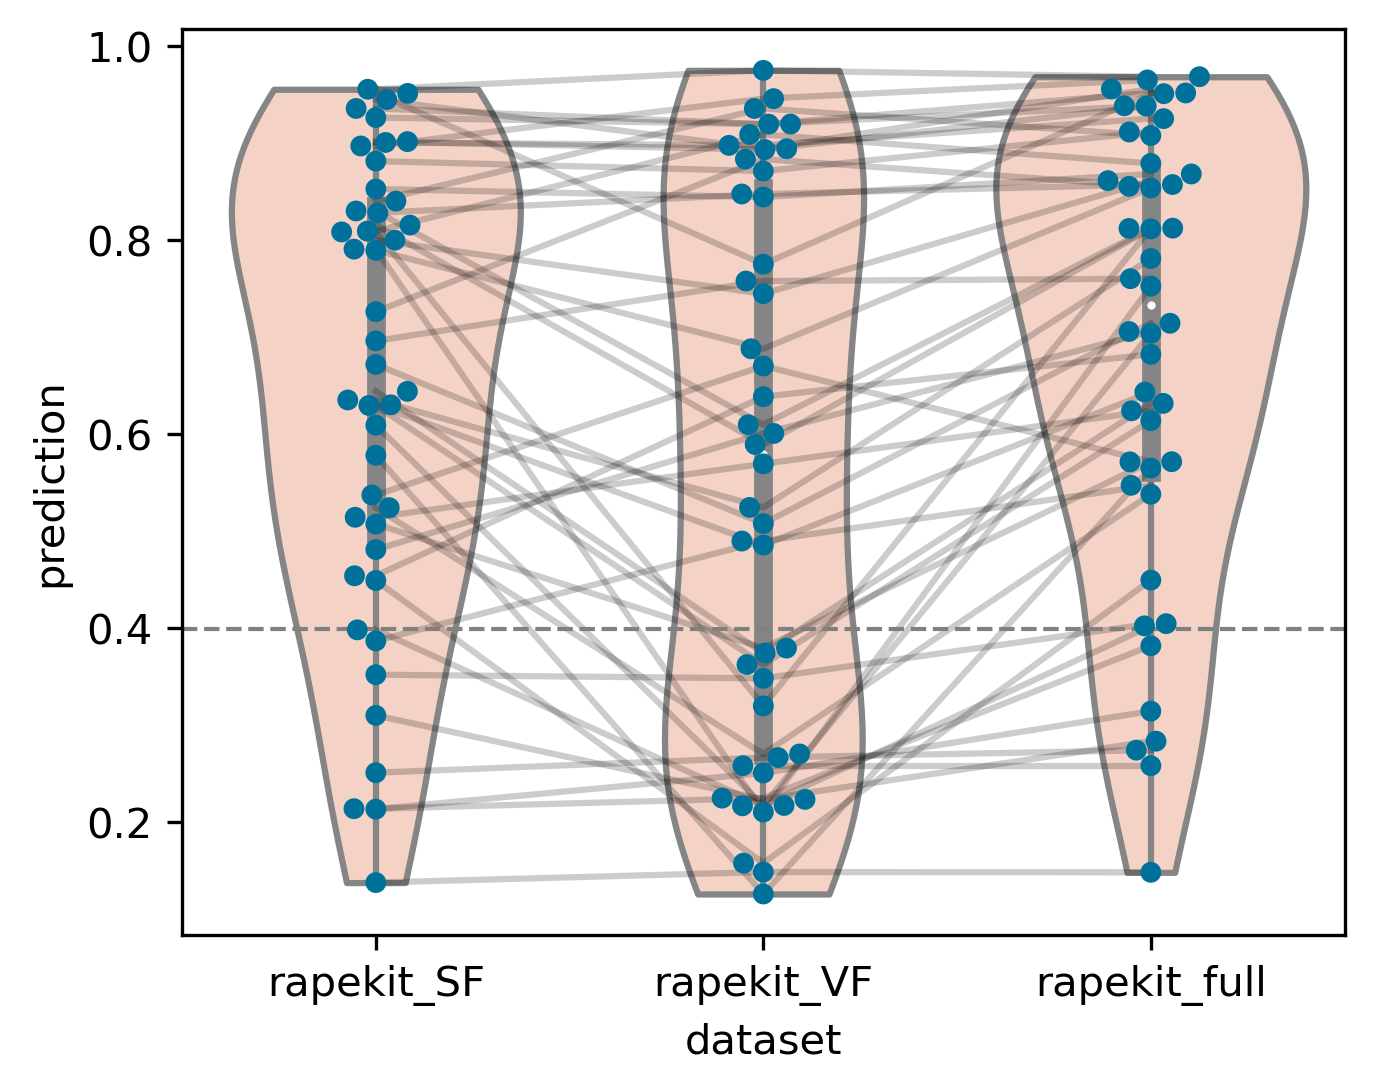

In [63]:
def plot_rapekit_preds_all_datasets(r):
    
    rkp = SA_rapekit.copy()
    if r == 'mean':
        rkp['prediction'] = rapekit_preds.mean(axis=1)
    else:
        rkp['prediction'] = rapekit_preds[r]
    #fi

    fig, axes = biu.utils.figure.subplots(ncols=1, figsize=(5,4))
    sns.violinplot(x='dataset', y='prediction', data=rkp, palette=[pink], cut=0, ax=axes[0])
    sns.swarmplot(x='dataset', y='prediction', data=rkp, color=blue, ax=axes[0])
    for i, row in rkp.pivot(index='SAS_number', columns='dataset', values='prediction').iterrows():
        plt.plot([0,1,2], row, alpha=0.2, c='k')

    xlim = axes[0].get_xlim()
    ylim = axes[0].get_ylim()

    #plt.plot([sel_thresh, sel_thresh], ylim, 'gray', linewidth=1, linestyle='dashed')
    plt.plot(xlim, [sel_thresh, sel_thresh], 'gray', linewidth=1, linestyle='dashed')

    axes[0].set_ylim(ylim)
    axes[0].set_xlim(xlim)
    return fig
#edef


from ipywidgets import interact, interactive, fixed, interact_manual, widgets
interact(lambda r: plot_rapekit_preds_all_datasets(r),
        r=list(rapekit_preds.columns) + ['mean'])

fig = plot_rapekit_preds_all_datasets('mean')
fig.savefig(biu.utils.fs.filename_today('/home/thies/repos/UA_underwear/paper_figures/rapekit_prediction_all_datasets','svg'))


# Make a table

In [42]:
method_names = ['precision', 'recall', 'FPR', 'TPR', 'FNR', 'TNR', 'accuracy', 'f1', 'auroc', 'auproc']
method_fns   = [ lambda p,g: precision(p>=sel_thresh,g),
                 lambda p,g: recall(p>=sel_thresh,g),
                 lambda p,g: FPR(p>=sel_thresh,g),
                 lambda p,g: TPR(p>=sel_thresh,g),
                 lambda p,g: FNR(p>=sel_thresh,g),
                 lambda p,g: TNR(p>=sel_thresh,g),
                 lambda p,g: accuracy(p>=sel_thresh,g),
                 lambda p,g: f1(p>=sel_thresh,g),
                 lambda p,g: auroc(roc_curve(g,p)),
                 lambda p,g: auproc(proc_curve(g,p))]

calc_scores = lambda p,g: [ (n, m(p,g)) for (n,m) in zip(method_names,method_fns) ]

score_table = []

## GENEDOE

In [43]:

g = SA_genedoe[SA_genedoe.explanation.isin(['Day 1', 'Day 2'])]['intercourse']
p = genedoe_preds[SA_genedoe.explanation.isin(['Day 1', 'Day 2'])]


score_table = score_table + [ ['Genedoe test', 'repeat %s' % r] + list(x)
                                 for r in p.columns
                                     for x in calc_scores(p[r],g) ]



## RAPEKIT

In [44]:
p = rapekit_preds
g = np.ones(SA_rapekit.shape[0])

score_table = score_table + [ ['Rapekit test', 'repeat %s' % r] + list(x)
                                 for r in p.columns
                                     for x in calc_scores(p[r],g) ]


In [45]:
score_table

[['Genedoe test', 'repeat X1', 'precision', 0.9],
 ['Genedoe test', 'repeat X1', 'recall', 0.9],
 ['Genedoe test', 'repeat X1', 'FPR', 0.1],
 ['Genedoe test', 'repeat X1', 'TPR', 0.9],
 ['Genedoe test', 'repeat X1', 'FNR', 0.09999999999999998],
 ['Genedoe test', 'repeat X1', 'TNR', 0.9],
 ['Genedoe test', 'repeat X1', 'accuracy', 0.9],
 ['Genedoe test', 'repeat X1', 'f1', 0.9],
 ['Genedoe test', 'repeat X1', 'auroc', 0.9750000000000004],
 ['Genedoe test', 'repeat X1', 'auproc', 0.9497222222222222],
 ['Genedoe test', 'repeat X1.1', 'precision', 0.8],
 ['Genedoe test', 'repeat X1.1', 'recall', 0.8],
 ['Genedoe test', 'repeat X1.1', 'FPR', 0.2],
 ['Genedoe test', 'repeat X1.1', 'TPR', 0.8],
 ['Genedoe test', 'repeat X1.1', 'FNR', 0.19999999999999996],
 ['Genedoe test', 'repeat X1.1', 'TNR', 0.8],
 ['Genedoe test', 'repeat X1.1', 'accuracy', 0.8],
 ['Genedoe test', 'repeat X1.1', 'f1', 0.8000000000000002],
 ['Genedoe test', 'repeat X1.1', 'auroc', 0.9550000000000004],
 ['Genedoe test', 're

## ISALA

In [46]:
yvar = "intercourse"
for r in range(nrepeats):
    foldcol = 'xv.%d.b.%d_folds' % (nfolds, r)
    predcol = 'xv.%d.b.%d_preds' % (nfolds, r)
    for f in range(nfolds):
        p = XV_isala[XV_isala[foldcol] == f][predcol]
        g = XV_isala[XV_isala[foldcol] == f][yvar]
        score_table = score_table + [ ['isala XV', foldcol + '.%d' % f] + list(x) for x in calc_scores(p,g) ]
    #efor
#efor

## Full table

In [47]:
score_table = pd.DataFrame(score_table, columns=['study','test','score','value'])

In [48]:
score_means = pd.pivot_table(score_table, index='score', columns='study', values='value', aggfunc=np.mean)
score_stds  = pd.pivot_table(score_table, index='score', columns='study', values='value', aggfunc=np.std)

st = score_means.applymap(lambda x: "NA" if pd.isna(x) else '%0.2f' % x) + '±' + score_stds.applymap(lambda x: "NA" if pd.isna(x) else '%0.2f' % x)

st.to_excel('analysis/prediction_results.xlsx')

st.applymap(str)

study     Genedoe test Rapekit test   isala XV
score                                         
FNR          0.15±0.05    0.23±0.03  0.19±0.06
FPR          0.21±0.07        NA±NA  0.39±0.08
TNR          0.79±0.07        NA±NA  0.61±0.08
TPR          0.85±0.05    0.77±0.03  0.81±0.06
accuracy     0.82±0.04    0.77±0.03  0.71±0.05
auproc       0.93±0.01    1.00±0.00  0.83±0.05
auroc        0.96±0.01    1.00±0.00  0.90±0.02
f1           0.83±0.04    0.87±0.02  0.74±0.04
precision    0.81±0.06    1.00±0.00  0.68±0.05
recall       0.85±0.05    0.77±0.03  0.81±0.06

<AxesSubplot:xlabel='score', ylabel='value'>

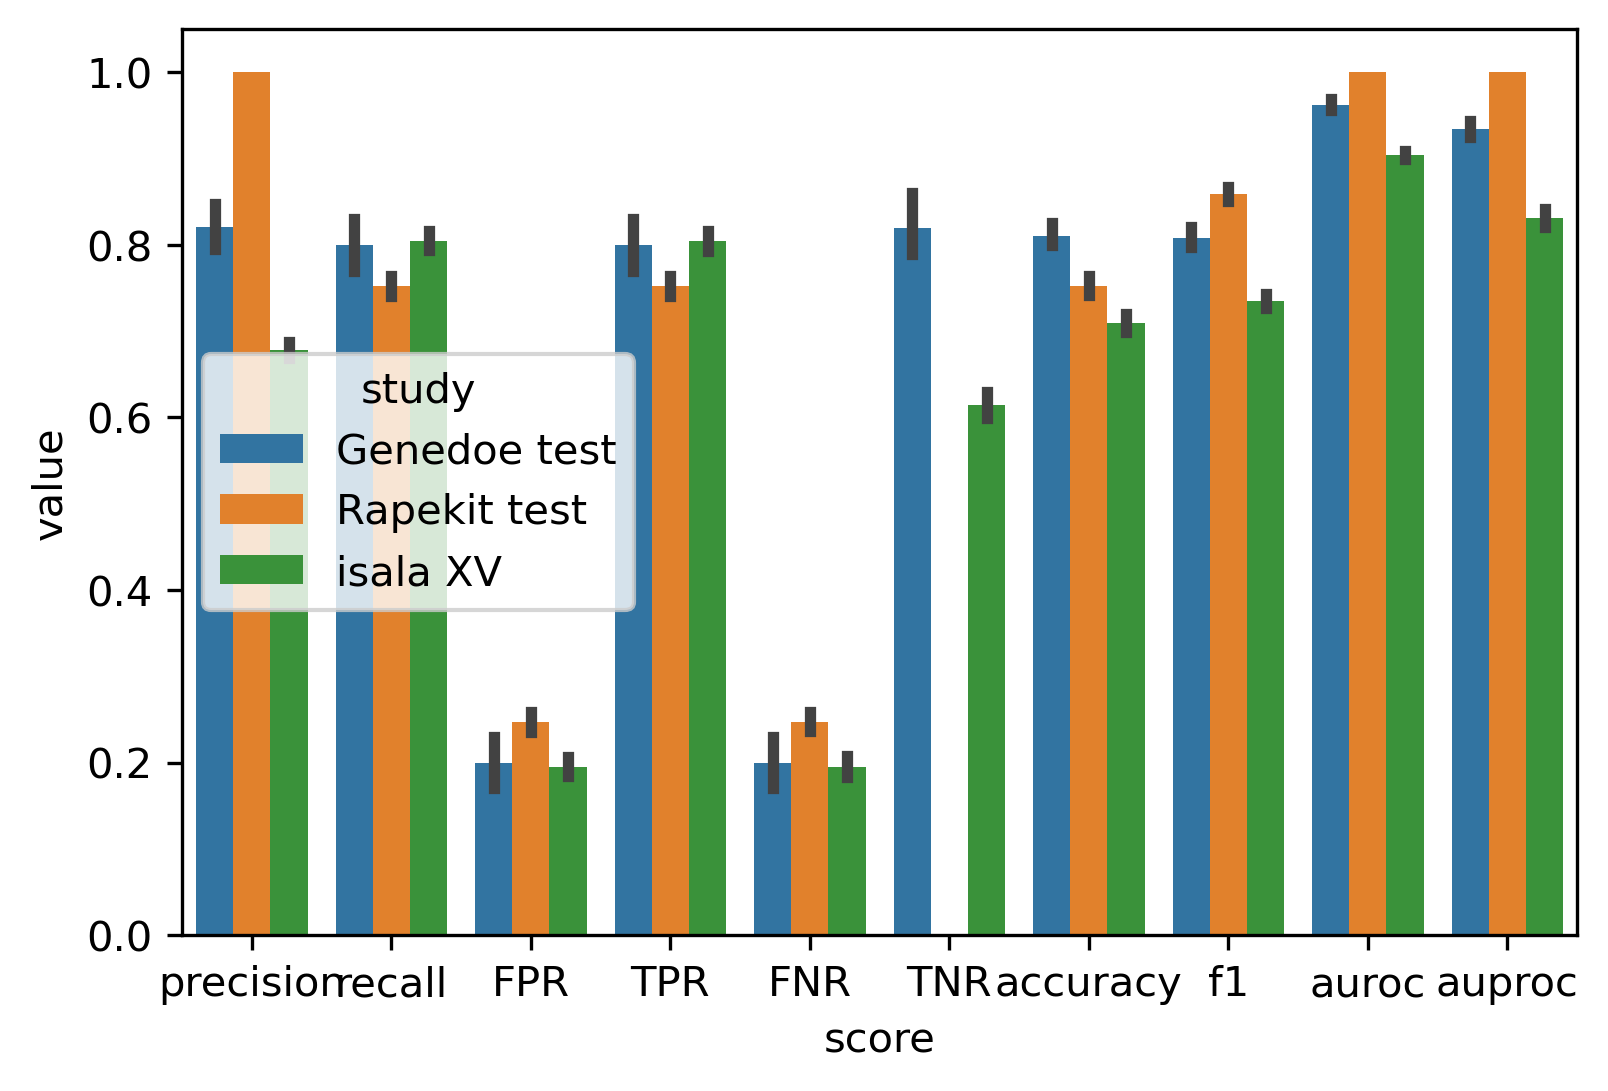

In [196]:
fig, axes = biu.utils.figure.subplots()
sns.barplot(x="score", y="value", hue="study", data=score_table, ax=axes[0])

# XGBoost predictor

In [176]:
import xgboost
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
scores = cross_val_score(XGBClassifier(), SA_isala[sel_taxa], SA_isala["intercourse"], cv=10)

In [177]:
print(scores)

[0.8781362  0.8781362  0.8781362  0.8781362  0.85304659 0.89247312
 0.86379928 0.88530466 0.87455197 0.88172043]


In [179]:
m = XGBClassifier()
m = m.fit(SA_isala[sel_taxa], SA_isala["intercourse"])

In [184]:
sum(m.predict(SA_rapekit[sel_taxa]))


46